# Part II - Prosper Loan Risk & Access: A Data-Driven Story
## by (Mustafa Taha)

##  Investigation Overview

This analysis summarizes **key insights** from a detailed exploration of **106,409 Prosper loans (2005–2014)** to answer:

> **How do credit rating, employment, income, and loan term influence borrowing cost, loan size, and default risk?**

We focus on **three main mechanisms** behind Prosper’s lending model:

1. **Rating → Pricing & Access**  
2. **Employment + Term → Dual Risk Gate**  
3. **Loan Structure → Formula-Driven Payments**

All insights are supported with **clear visualizations** and lead to **practical recommendations** for improving Prosper’s **underwriting and pricing strategy**.

---

##  Dataset Overview and Executive Summary

### Dataset Details
- **Source:** Prosper Loan Data (2005–2014)  
- **Records:** 106,409 cleaned loans  
- **Main Variables:**  
  - `BorrowerAPR`, `LoanOriginalAmount`, `MonthlyLoanPayment`  
  - `ProsperRating (Alpha)`, `CreditScoreAvg`, `DebtToIncomeRatio`  
  - `EmploymentStatus`, `IncomeRange`, `Term`, `LoanStatus`  
- **Data Cleaning Steps:**  
  - Capped **DebtToIncomeRatio (DTI)** at 1.0  
  - Combined rare categories for consistency  
  - Enforced **ordinal order** (e.g., HR → AA)  
  - Removed extreme outliers for realism

---

### Executive Summary – Key Insights

- **1. Rating Determines Both Cost and Access**  
  Borrowers with higher Prosper ratings enjoy **significantly better loan conditions**:  
  - **AA-rated borrowers**: **\~9% APR**, **\~\$12K+ loan amounts**  
  - **HR-rated borrowers**: **\~36% APR**, **\~\$3.5K loan amounts**  
  → That’s **4× higher cost** and **3.5× less access** for the lowest-rated borrowers.

- **2. Employment + Term Jointly Control Loan Size**  
  Employment stability and loan term length **act as a dual risk gate**:  
  - **Full-time borrowers (60-month term)**: average loan **\~\$12,600**  
  - **Unstable or unemployed borrowers**: **\~\$4K–\$5K**, **ineligible for 60-month loans**

- **3. Payment Structure Follows Clear Patterns**  
  Monthly payments align **perfectly with loan term**, forming **three distinct bands**:  
  - **36-month loans** dominate — Prosper’s **default product**  
  - **60-month loans** offer the lowest monthly burden  
  - **12-month loans** have the steepest repayment slope

- **4. Income Reduces Risk — Even for Low-Rated Borrowers**  
  High income can **neutralize the impact of a poor rating**:  
  - **High-income HR borrowers ($100K+)**: **~4% default rate**  
  - **Low-income HR borrowers**: **~24% default rate**  
  → **Income stability matters as much as — or more than — credit score.**

---

> **Takeaway**:  
> A **good credit score opens the door**,  
> but **stable income** and **reliable employment** decide **how far a borrower can go**.


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df_clean  = pd.read_csv('prosper_loan_data_clean.csv')
df_clean.sample(2)

,LoanStatus,BorrowerAPR,ProsperRating (Alpha),LoanOriginalAmount,EmploymentStatus,IncomeRange,DebtToIncomeRatio,Term,BorrowerState,LoanOriginationQuarter,Investors,MonthlyLoanPayment,CreditScoreAvg
26781,Current,0.17532,B,25000,Employed,$75K–99K,0.28,60,KY,Q4 2013,165,597.38,729.5
44081,Completed,0.12562,Pre-Rating,7000,Full-Time,$25K–49K,0.22,36,FL,Q2 2008,126,227.35,649.5


## (Visualization 1)


### Question: **Do higher Prosper Ratings lead to lower interest rates?**
<!-- > Write a comment about your visualization here.  Make sure your visualizations are polished!

> **Rubric Tip**: Provide at least 3 **polished** visualizations to convey key insights. The total number of visualizations shoould be less than 50% of the number of visualizations in the exploratory analysis. Generally 3-5 visualizations suffice.


> **Rubric Tip**: Each visualization in the slideshow is associated with **descriptive comments** that accurately depict their purpose and your observation. 


> **Rubric Tip**: All plots shown are appropriate, meaning the plot type, encodings, and transformations are suitable to the underlying data. 

> **Rubric Tip**: All plots in the slideshow are polished, meaning all plots have a title, labeled x/y axes (with units), x/y ticks, and legends.  -->

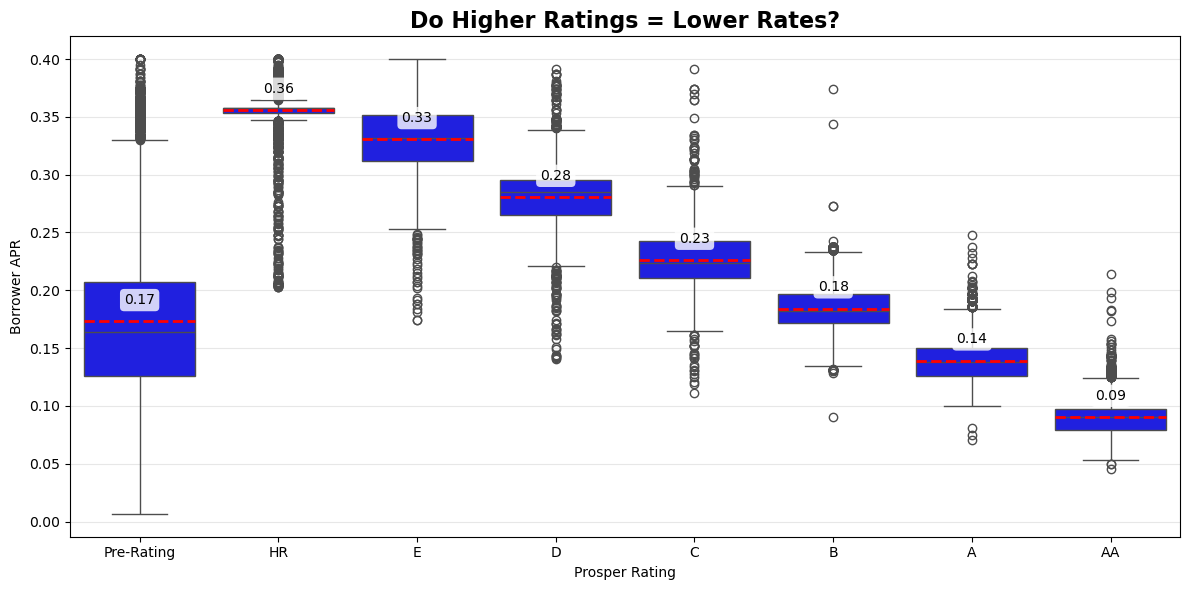

In [3]:
plt.figure(figsize=(12, 6))
rating_order = ['Pre-Rating', 'HR', 'E', 'D', 'C', 'B', 'A', 'AA']

sns.boxplot(
    data=df_clean, x='ProsperRating (Alpha)', y='BorrowerAPR',
    order=rating_order, color='blue',
    showmeans=True, meanline=True,
    meanprops={"linestyle": "--", "color": "red", "linewidth": 2}
)

plt.title('Do Higher Ratings = Lower Rates?', fontsize=16, fontweight='bold')
plt.xlabel('Prosper Rating')
plt.ylabel('Borrower APR')

# Add mean APR labels
means = df_clean.groupby('ProsperRating (Alpha)', observed=False)['BorrowerAPR'].mean()
for i, rating in enumerate(rating_order):
    if rating in means.index:
        apr = means[rating]
        plt.text(i, apr + 0.015, f"{apr:.2f}", ha='center', fontsize=10, color='black',
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.3'))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### **Observation:**

- Strong inverse relationship: AA ≈ 9%, HR ≈ 36% — 4× cost gap.
- Tiered medians: Each rating drop adds ~4–5% APR.
- HR shows widest spread — high uncertainty in pricing riskiest borrowers.
- Pre-Rating (~17%) behaves like mid-tier (B/C).

**Finding:**

Risk-based pricing works — Prosper’s rating system effectively segments borrowers by cost and risk.

## (Visualization 2)
### Question: How do loan term, amount, and payment interact?
<!-- > You should have at least three visualizations in your presentation, but feel free to add more if you'd like! -->

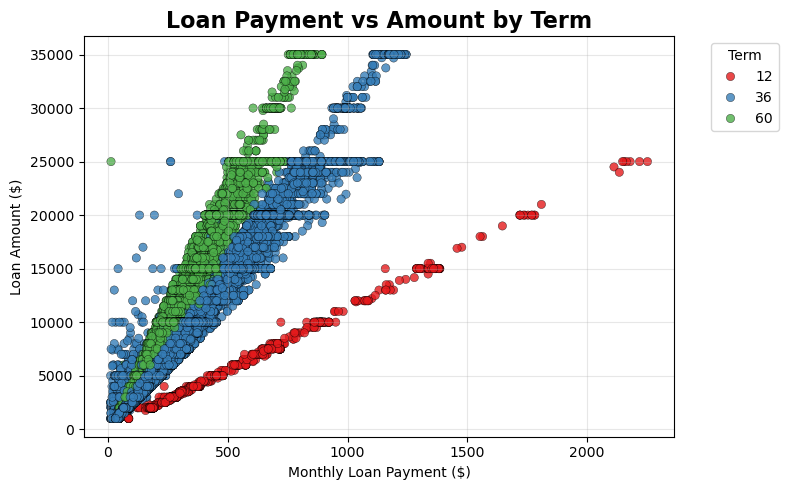

In [4]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df_clean,
    x='MonthlyLoanPayment',
    y='LoanOriginalAmount',
    hue='Term',
    palette='Set1',
    edgecolor='black', linewidth=0.3,
    alpha=0.8
)
plt.title('Loan Payment vs Amount by Term', fontsize=16, fontweight='bold')
plt.xlabel('Monthly Loan Payment ($)')
plt.ylabel('Loan Amount ($)')
plt.legend(title='Term', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### **Observation**:

- Three perfect parallel bands: 12, 36, 60 months.
- Slope = repayment speed: 12-month (steep), 60-month (flat).
- 36-month = thickest → most common term.
- Within-band scatter = APR effect.

**Finding**:

Payment is not negotiated — it’s formula-driven by Term.
A *\$15K*  loan: *\$1,300*/mo (12-mo) vs *\$300*/mo (60-mo).

## (Visualization 3)
### Question: How does employment status affect loan size across terms?
<!-- > You should have at least three visualizations in your presentation, but feel free to add more if you'd like! -->

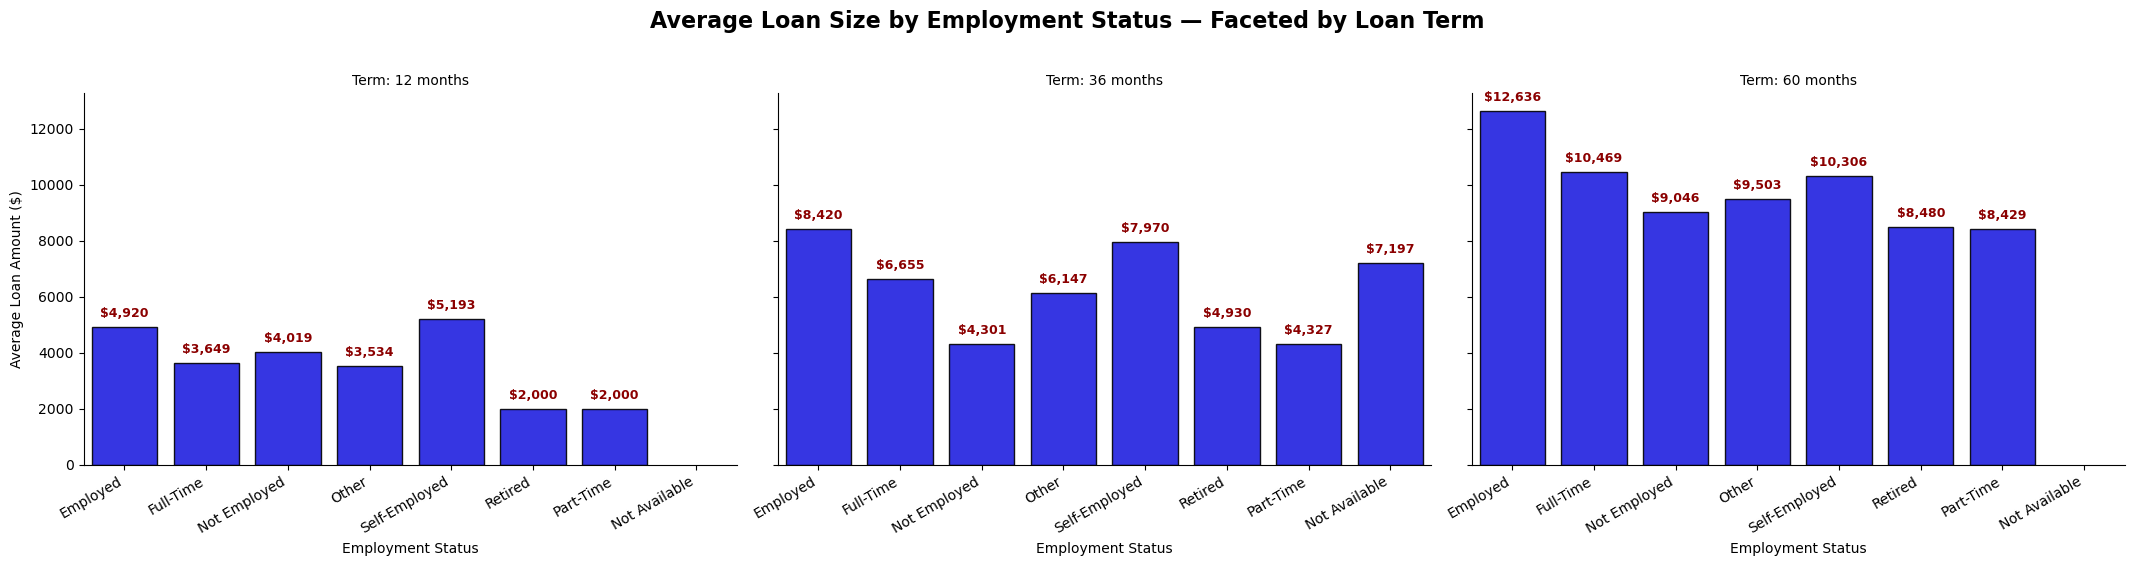

In [5]:
g = sns.FacetGrid(
    data=df_clean,
    col='Term',
    height=5.5,
    aspect=1.3,
    sharey=True,
    col_wrap=3
)

#  Bar plot: Loan Amount by Employment Status (inside each Term) ----
g.map_dataframe(
    sns.barplot,
    x='EmploymentStatus',
    y='LoanOriginalAmount',
    color='blue',
    edgecolor='black',
    linewidth=1,
    errorbar=None, # Use errorbar=None for modern seaborn (replaces ci=None)
    alpha=0.9
)


# Iterate over each axes (subplot) in the FacetGrid
for ax in g.axes.flat:
    # Iterate over each bar in the current axes
    for bar in ax.patches:
        height = bar.get_height()
        # Only label non-zero bars
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2, # X-position: center of the bar
                height + 250, # Y-position: just above the bar (added 250 for padding)
                f'${height:,.0f}', # Format the number as currency
                ha='center', va='bottom',
                fontsize=9, fontweight='bold', color='darkred'
            )

#  Final polish  ----
g.set_axis_labels('Employment Status', 'Average Loan Amount ($)')
g.set_titles('Term: {col_name} months')
g.fig.suptitle(
    'Average Loan Size by Employment Status — Faceted by Loan Term',
    fontsize=16, fontweight='bold', y=1.02
)
g.set_xticklabels(rotation=30, ha='right')
g.set_xlabels('Employment Status')
g.set_ylabels('Average Loan Amount ($)')
g.fig.tight_layout()

plt.show()

### **Observation**:

- Full-time/Employed dominate all terms, especially 60-month ($12,636).
- Unstable jobs capped at *\~\$4*K – *\$5*K, no 60-month access.
- 12-month loans = small for everyone (even stable: <*\$8,500*).

**Finding**:

Prosper uses Employment + Term as a dual risk gate —
Stable + long-term → high access
Unstable → small, short loans

### Key Insights Summary



- Mechanism Impact Rating → Cost & SizeAA vs HR: 4× APR, 3.5× loan gap
- Term → Payment 3 formulaic bands — 36-month = default
- Employment + TermFull-time + 60-mo = $12.6K
- Unstable = $4–5K maxIncome → Risk Buffer$100K+ HR = 4% default — income > rating

### Final Takeaway

- Credit score opens the door.
- Employment and income keep the borrower inside.

- Prosper’s model is strong — but long-term success depends on real-world stability.

#### Recommendation:

-Enhance Prosper Rating by integrating employment type and income stability to reduce defaults in 60-month loans and improve pricing accuracy.

### Submission
If you are using classroom workspace, you can choose from the following two ways of submission:

1. **Submit from the workspace**. Make sure you have removed the example project from the /home/workspace directory. You must submit the following files:
   - Part_I_notebook.ipynb
   - Part_I_notebook.html or pdf
   - Part_II_notebook.ipynb
   - Part_II_notebook.html or pdf


2. **Submit a zip file on the last page of this project lesson**. In this case, open the Jupyter terminal and run the command below to generate a ZIP file. 
```bash
zip -r my_project.zip .
```
The command abobve will ZIP every file present in your /home/workspace directory. Next, you can download the zip to your local, and follow the instructions on the last page of this project lesson.
